In [1]:

!pip install imutils

import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=bbeeff0750b88a6c55b5548fb68064e0ca6eace0d81ee7d70fe5e5750eb882d4
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/mr-image-converterr/MRI/MRI/Training/pituitary/Tr-p

In [2]:
!pip install scikit-learn


In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Create a directory named 'Crop-Brain-MRI' 
os.mkdir('/kaggle/working/Crop-Brain-MRI')
os.mkdir('/kaggle/working/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/kaggle/working/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/kaggle/working/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/kaggle/working/Crop-Brain-MRI/no_tumor')

In [5]:
#create directory for testing data
os.mkdir('/kaggle/working/Test-Data')
os.mkdir('/kaggle/working/Test-Data/glioma_tumor')
os.mkdir('/kaggle/working/Test-Data/meningioma_tumor')
os.mkdir('/kaggle/working/Test-Data/pituitary_tumor')
os.mkdir('/kaggle/working/Test-Data/no_tumor')

In [6]:
#specify directory
train_dir = '/kaggle/input/mr-image-converterr/MRI/MRI/Testing/'
test_dir = '/kaggle/input/mr-image-converterr/MRI/MRI/Testing/'

In [7]:
#create classes
classes = os.listdir('/kaggle/input/mr-image-converterr/MRI/MRI/Training')

In [8]:
classes

['pituitary', 'notumor', 'meningioma', 'glioma']

In [9]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

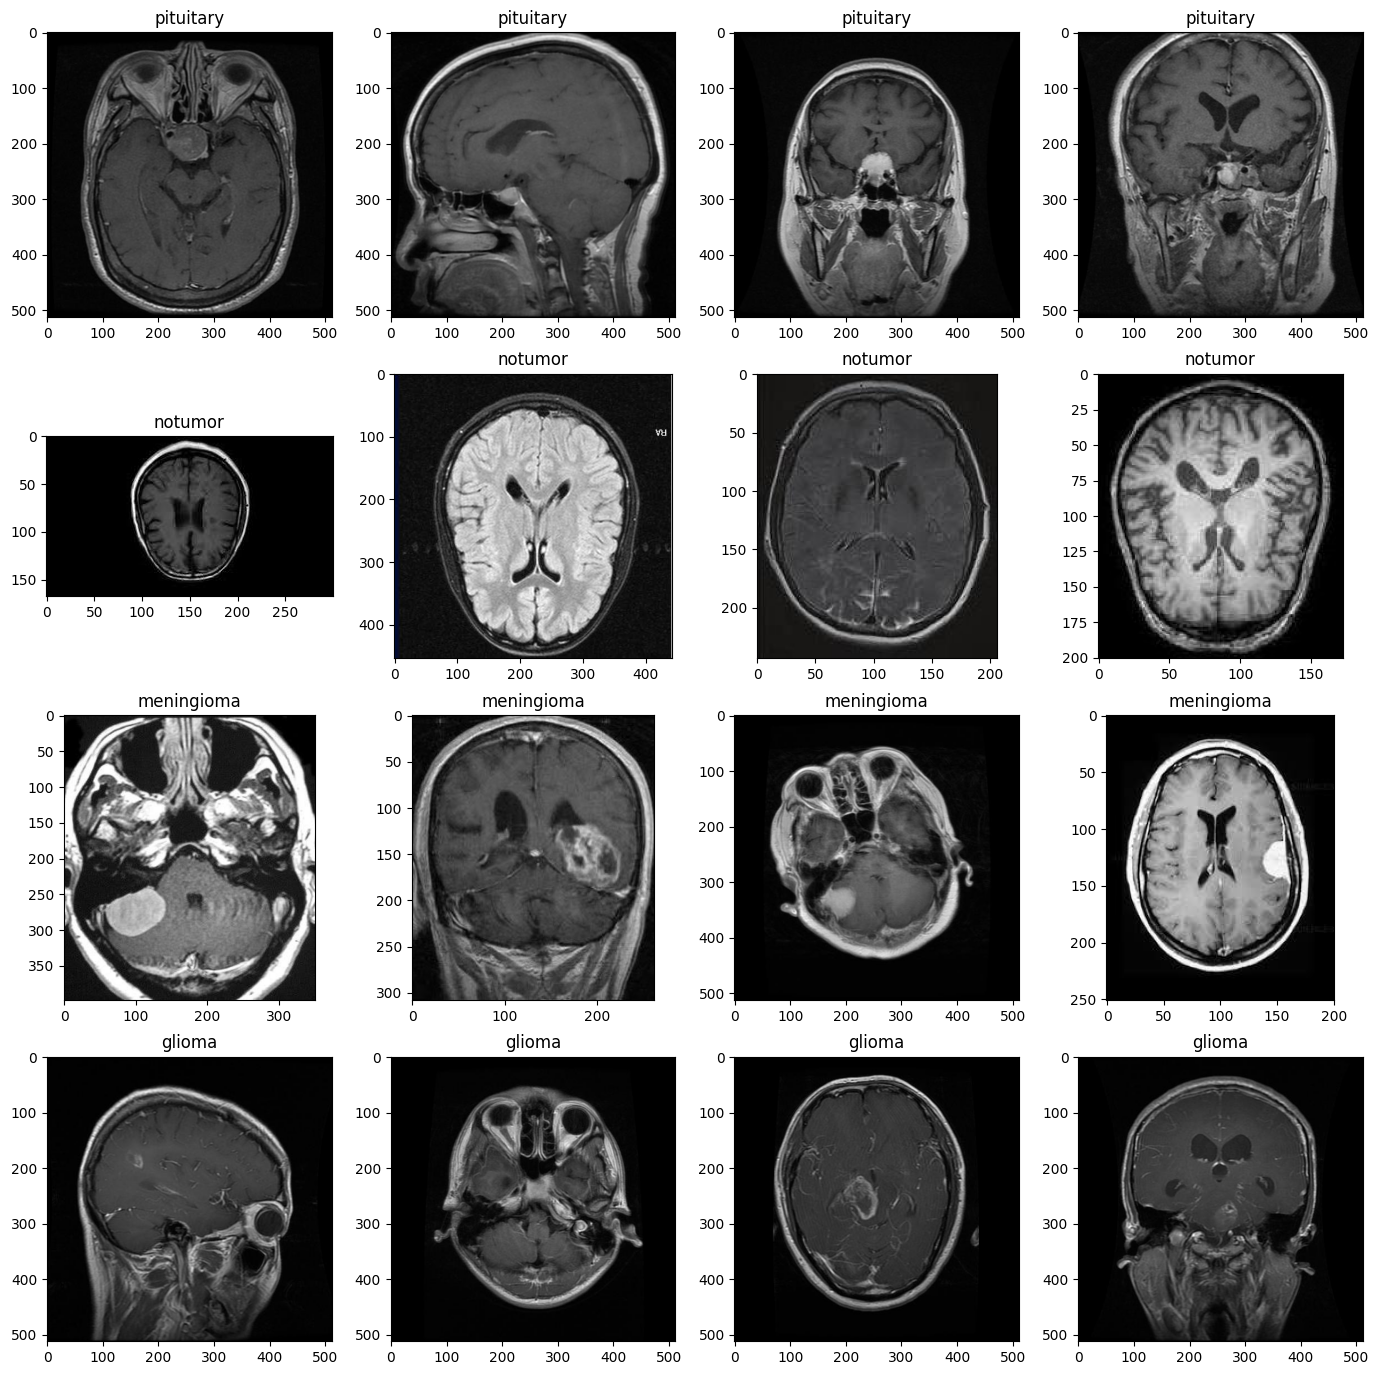

In [11]:
# Set the size of the figure to 17x17 inches.
plt.figure(figsize = (17,17))
index = 0

# Iterate through each class in the 'classes' list
for c in classes:
# Shuffle the list of file paths for the current class to introduce randomness.
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]
# Iterate through each class in the 'classes' list.
  for i in range(1, 5):
    index += 1
# Create a subplot in a 4x4 grid, and display the image from the current path.
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [12]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('/kaggle/input/mr-image-converterr/MRI/MRI/Training'):
  train_class = os.listdir(os.path.join('/kaggle/input/mr-image-converterr/MRI/MRI/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in pituitary = 1457 

Number of images in notumor = 1591 

Number of images in meningioma = 1339 

Number of images in glioma = 1321 



In [13]:
# Initialize lists to store the number of images per class and class names.
No_images_per_class = []
Class_name = []

# Iterate through class directories in the 'Training' directory, count images per class,
# and print the results.
for i in os.listdir('/kaggle/input/mr-image-converterr/MRI/MRI/Training'):
  train_class = os.listdir(os.path.join('/kaggle/input/mr-image-converterr/MRI/MRI/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in pituitary = 1457 

Number of images in notumor = 1591 

Number of images in meningioma = 1339 

Number of images in glioma = 1321 



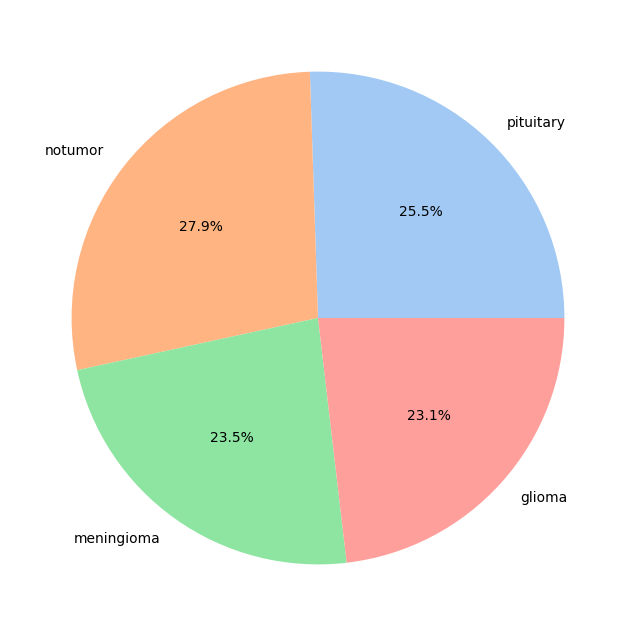

In [14]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [15]:
def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

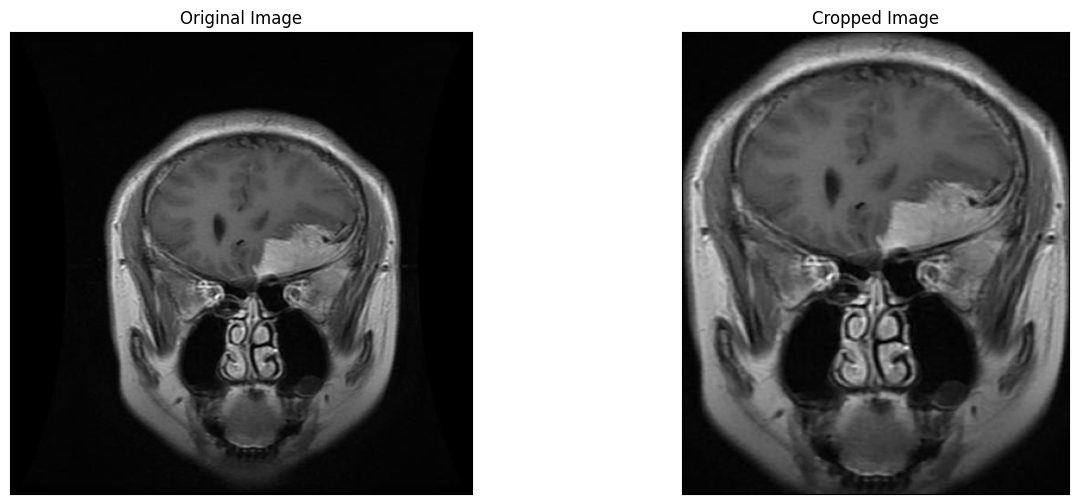

In [16]:
# Use the 'crop_image' function to obtain a cropped version of the example image.
example_image = cv2.imread('/kaggle/input/mr-image-converterr/MRI/MRI/Training/meningioma/Tr-meTr_0000.jpg')
cropped_image = crop_image(example_image, plot=True)

In [17]:
#crop training images and save it to the directory we previously created
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'

j = 0
# Process images in the 'glioma' class directory.
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0

# Similar processing for the 'meningioma' class.
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0

# Similar processing for the 'pituitary' class.
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0

# Similar processing for the 'no_tumor' class.
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|██████████| 405/405 [00:03<00:00, 127.20it/s]


In [18]:
#crop testing images and save it to the directory we previously created
test_glioma = test_dir + 'glioma'
test_meningioma = test_dir + 'meningioma'
test_pituitary = test_dir + 'pituitary'
test_no_tumor = test_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/kaggle/working/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|██████████| 405/405 [00:02<00:00, 191.51it/s]


In [20]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('/kaggle/working/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('/kaggle/working/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/kaggle/working/Test-Data/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)

Found 1049 images belonging to 4 classes.
Found 262 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [22]:
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


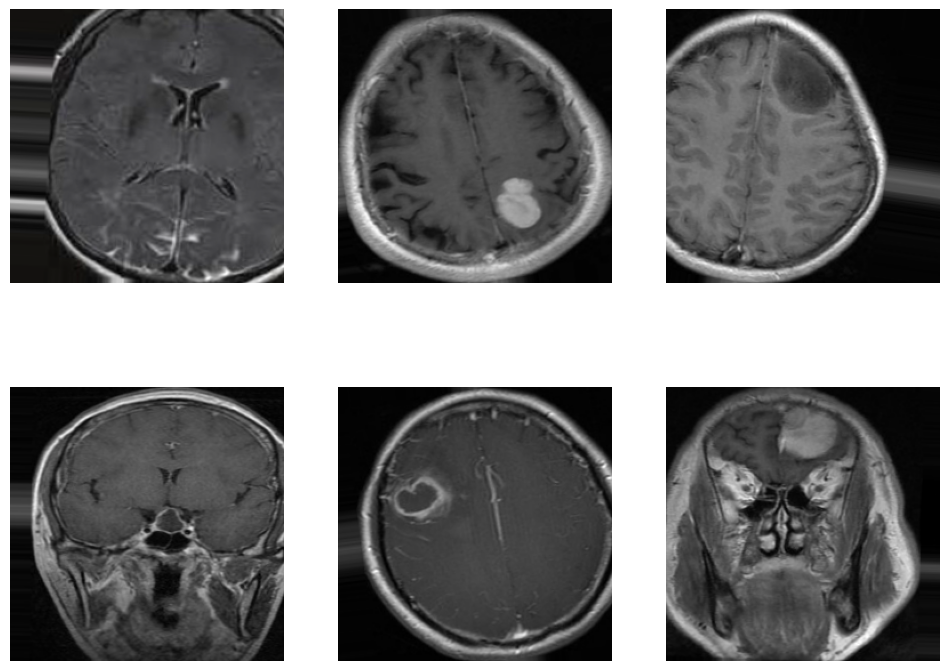

In [23]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

In [24]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(240, 240, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 240, 240, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 240, 240, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [26]:
#compile model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [27]:
%%time

#train the model
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30


2024-01-14 07:17:08.448174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


33/33 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7846
Epoch 1: val_accuracy improved from -inf to 0.77863, saving model to model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 81s 658ms/step - loss: 0.5571 - accuracy: 0.7846 - val_loss: 0.6187 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 0.9390
Epoch 2: val_accuracy improved from 0.77863 to 0.83206, saving model to model.h5
33/33 [==============================] - 18s 547ms/step - loss: 0.1848 - accuracy: 0.9390 - val_loss: 0.6372 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9304
Epoch 3: val_accuracy improved from 0.83206 to 0.88931, saving model to model.h5
33/33 [==============================] - 18s 546ms/step - loss: 0.2009 - accuracy: 0.9304 - val_loss: 0.4058 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9514
Epoch 4: val_accuracy improved from 0.88931 to 0.89313, saving model to model.h5
33/33 [==============================] -

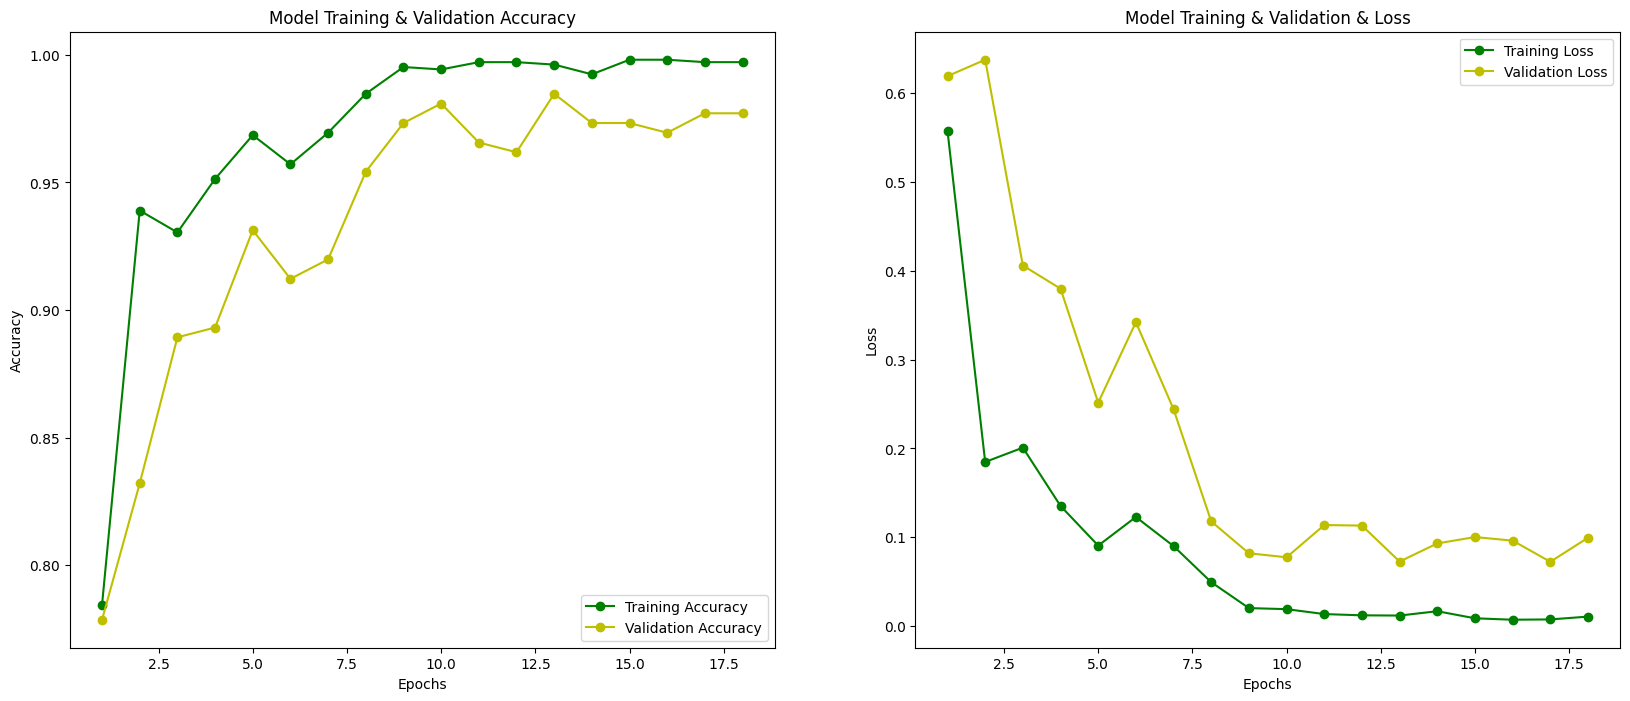

In [28]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [29]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

33/33 [==============================] - 14s 427ms/step - loss: 0.0020 - accuracy: 0.9990
Train accuracy & loss: [0.001994948135688901, 0.9990466833114624]


41/41 [==============================] - 17s 420ms/step - loss: 0.0184 - accuracy: 0.9947
Test accuracy & loss: [0.018396520987153053, 0.9946605563163757]


In [30]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

41/41 [==============================] - 19s 393ms/step


In [31]:
y_test

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [32]:
yhat_test

array([0, 1, 0, ..., 3, 3, 3])

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[297   3   0   0]
 [  1 304   1   0]
 [  0   1 404   0]
 [  0   2   0 298]]


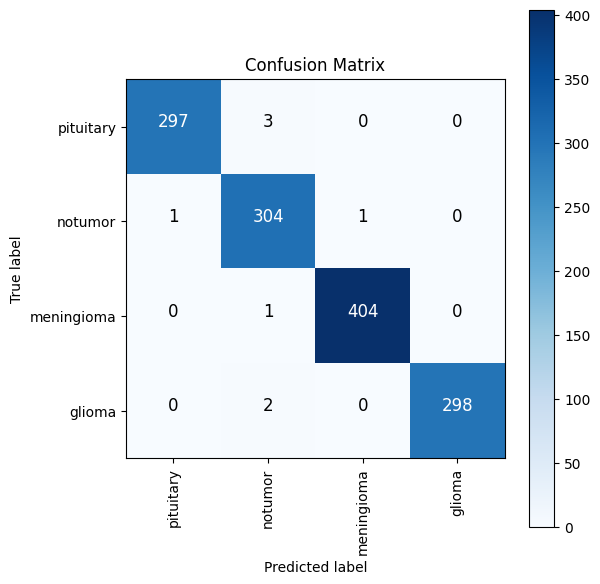

In [35]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [36]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       0.98      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [37]:
import PIL

class_dict = {0: 'glioma_tumor',
              1: 'meningioma_tumor',
              2: 'no_tumor',
              3: 'pituitary_tumor'}
              
prediction = []
original = []
image = []
count = 0
for i in os.listdir('/kaggle/working/Test-Data/'):
  for item in os.listdir(os.path.join('/kaggle/working/Test-Data', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('/kaggle/working/Test-Data', i, item))
    #append to image list
    image.append(img)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    #predict
    predict = model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict])
    #append original class to the list
    original.append(i)

1/1 [==============================] - 0s 27ms/step


In [38]:
#test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.9900839054157132


IndexError: list index out of range

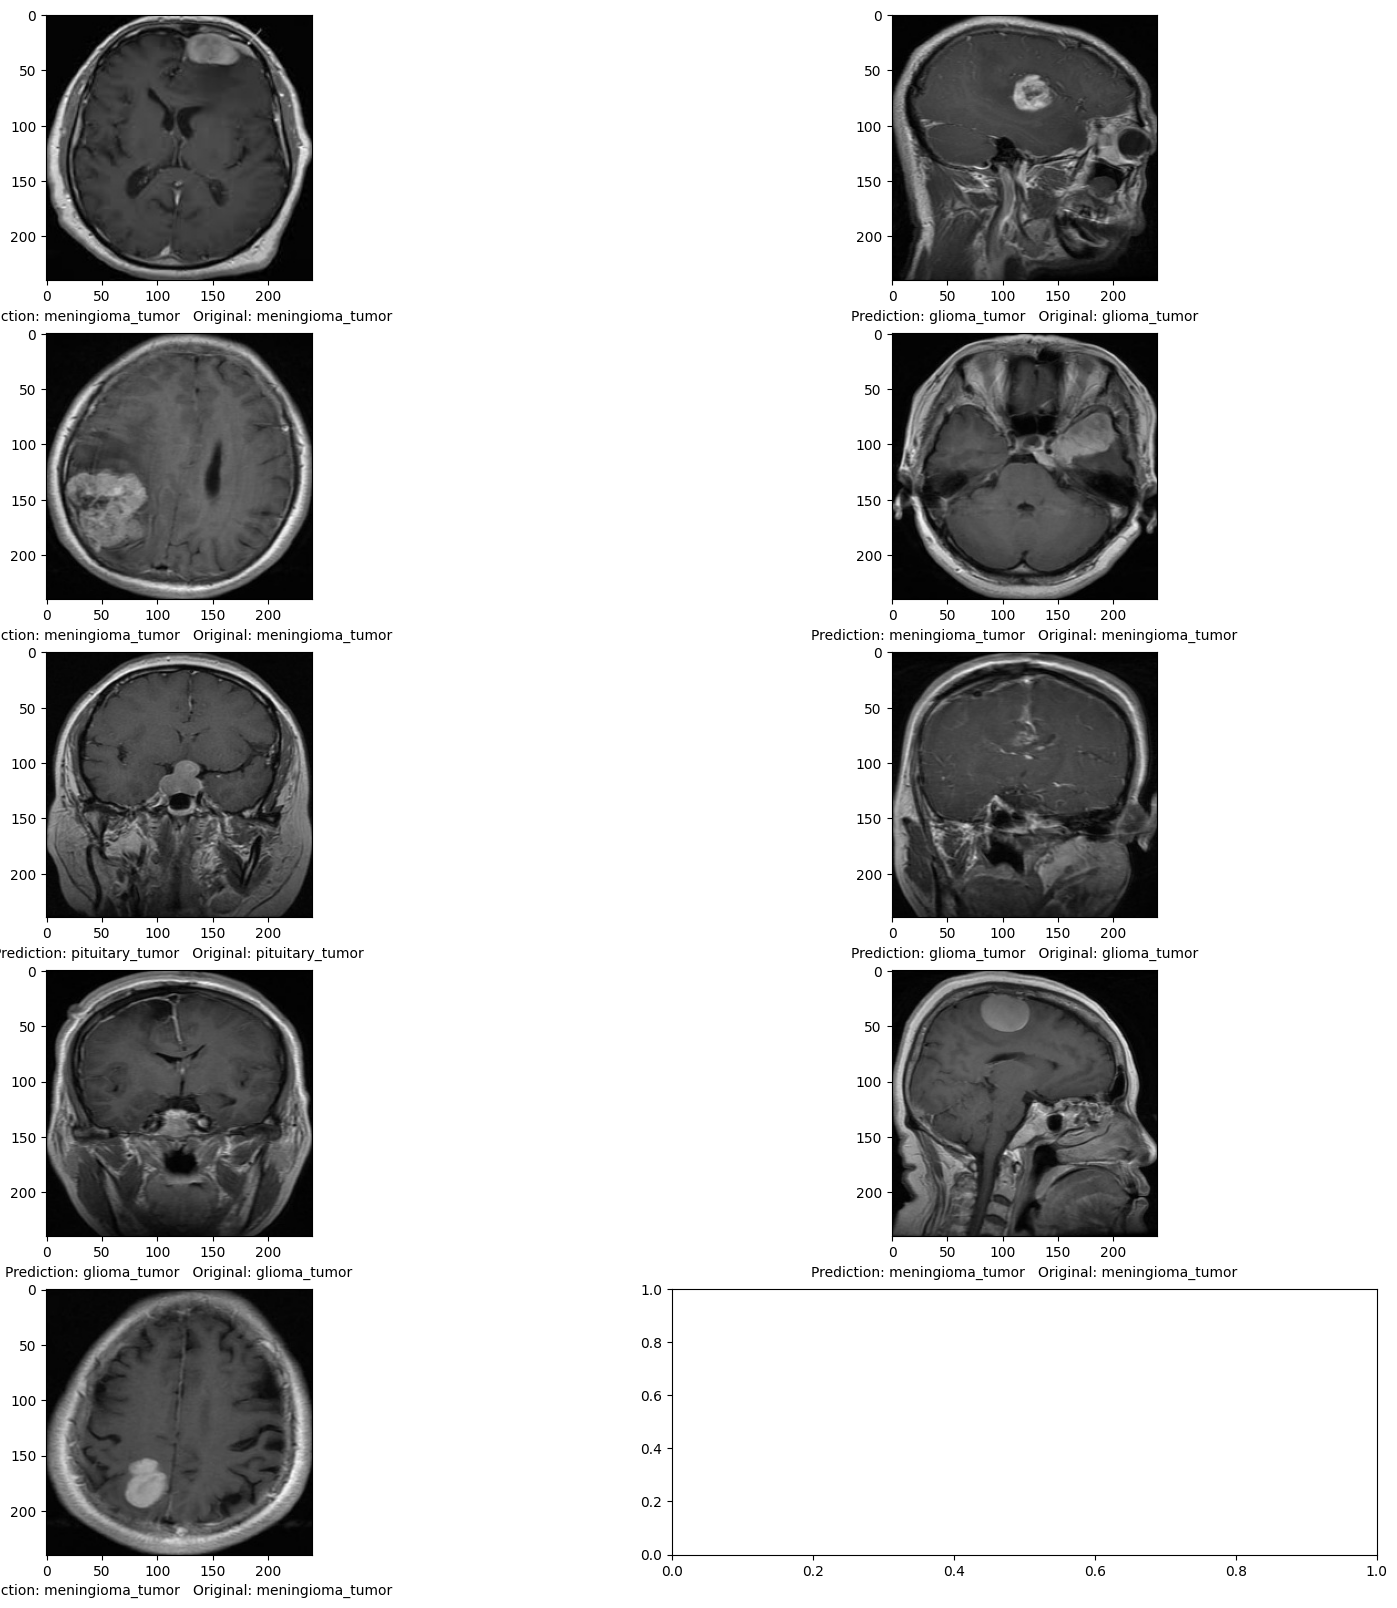

In [39]:
#visualize the results
fig = plt.figure(figsize = (20, 20))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

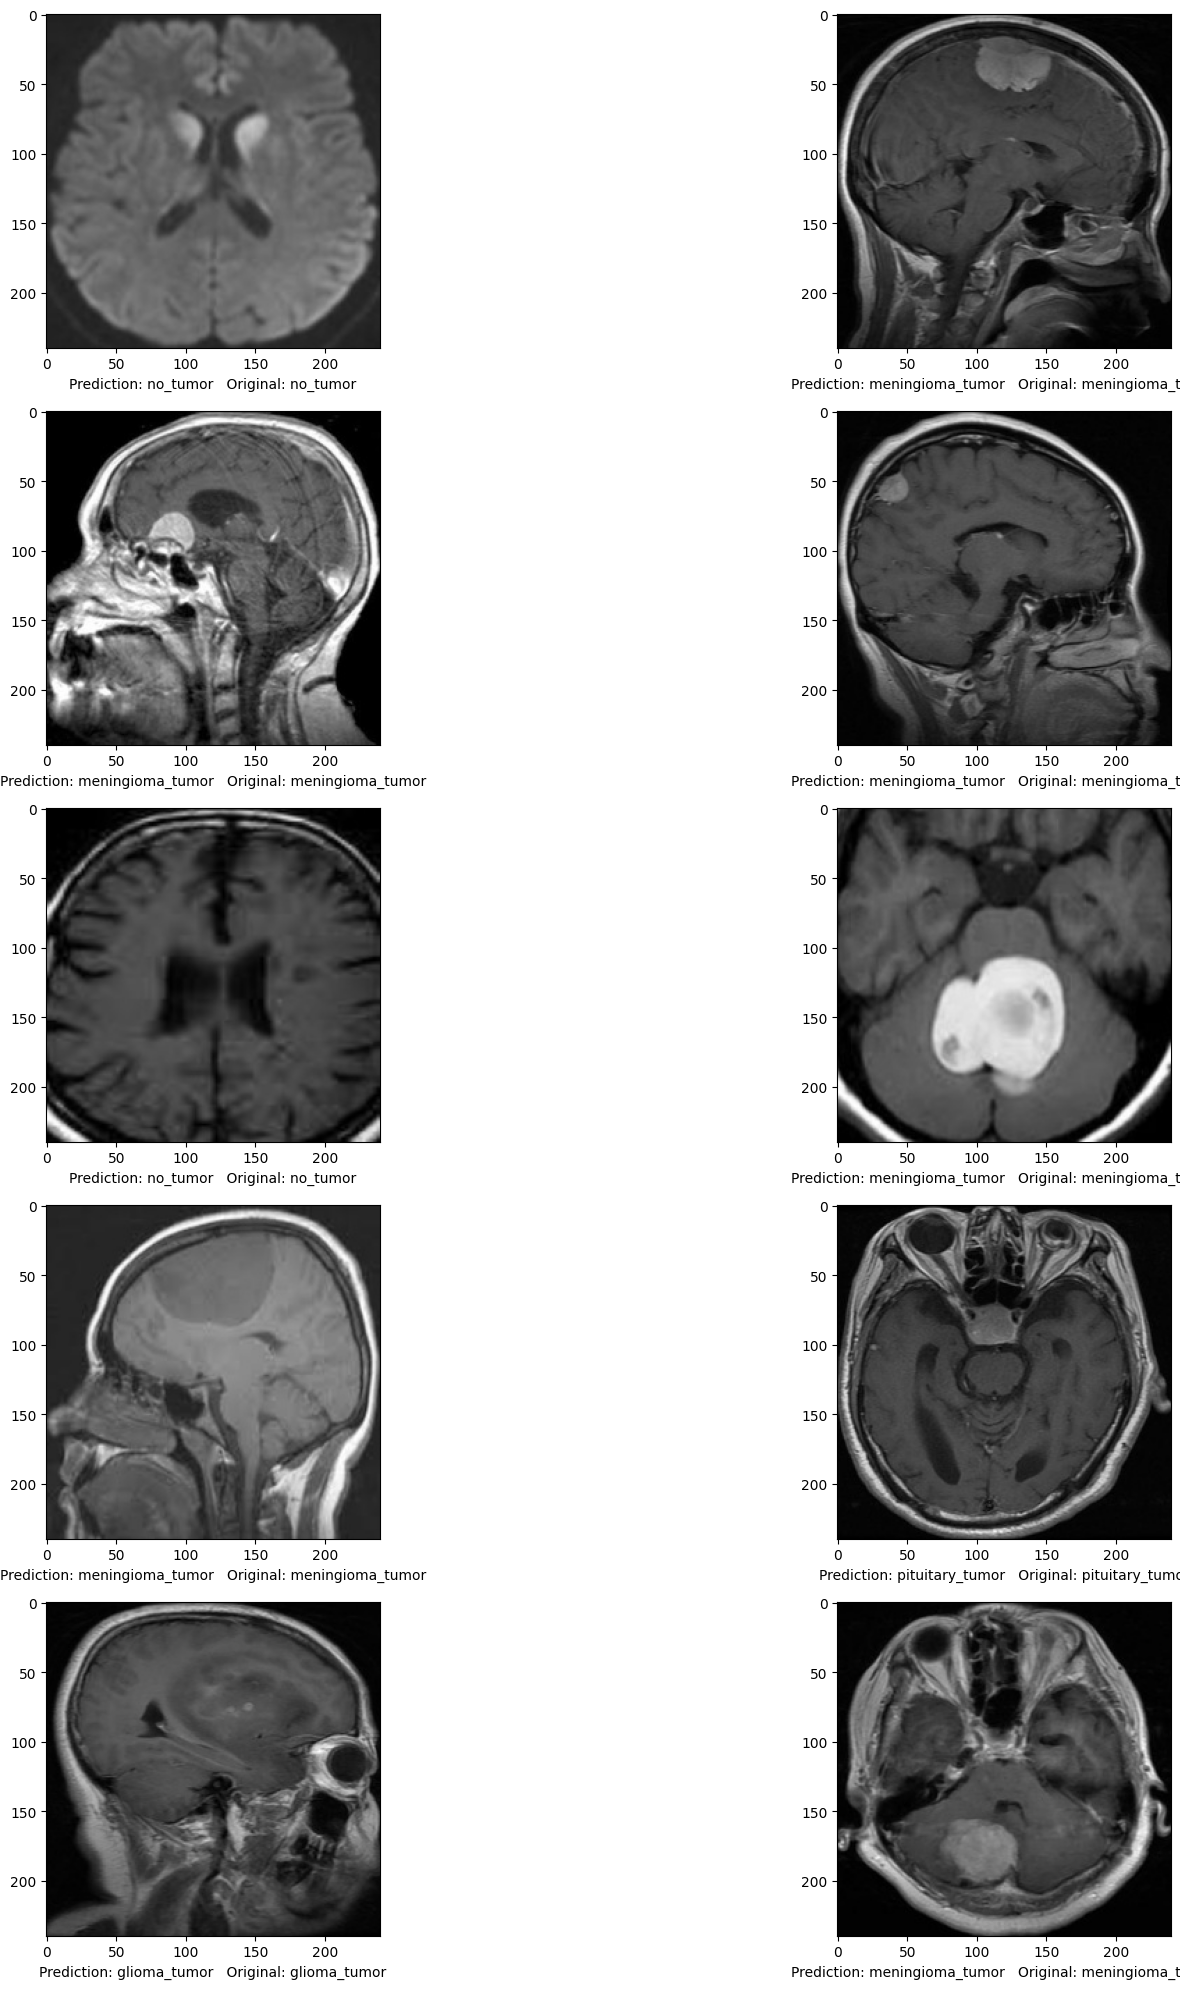

In [40]:
#visualize the results
fig = plt.figure(figsize = (20, 20))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [41]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [43]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    #VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    #using the gradients from the last convolutional layer
    #plot_results (boolean): True - Function Plots using PLT False - Returns Heatmap Array
    
    #sanity check
    assert (interpolant > 0 and interpolant < 1), #Heatmap Interpolation Must Be Between 0 - 1

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 [==============================] - 2s 2s/step


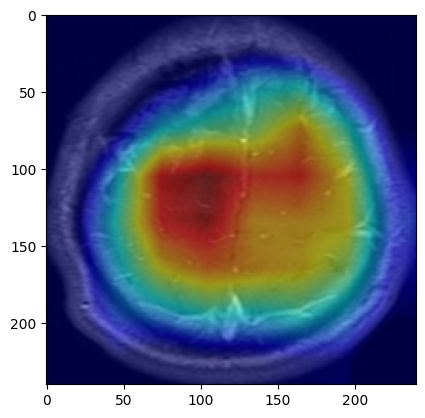

In [45]:
#load image
test_img = cv2.imread("/kaggle/working/Test-Data/glioma_tumor/158.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 [==============================] - 0s 28ms/step


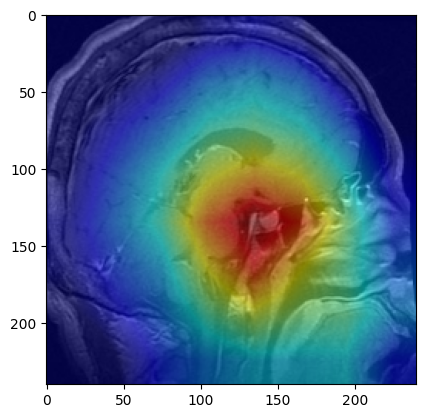

In [47]:
#load image
test_img = cv2.imread("/kaggle/working/Test-Data/pituitary_tumor/158.jpg")

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)